In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

In [2]:
rootpath = "data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load behavior data
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

# preprocess behavior data
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict)
static_behaviors = {'choice': choices, 'stimulus': one_hot_stimuli}

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


all

In [4]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=True, samp_freq=samp_freq)

# load kilosort units that passed ibl's quality metrics
good_ks_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi='all', keep_active_trials = True, samp_freq=30_000)

In [5]:
# # load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

# # load clusterless model
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

# load gmm after split-merge
# k_means_init_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, init_method='k-means++', fit_model=False)
# k_means_init_labels = k_means_init_gmm.predict(structured_unsorted)
# k_means_init_probs = k_means_init_gmm.predict_proba(structured_unsorted)

sorting_init_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, init_method='sorting', fit_model=False)
sorting_init_labels = sorting_init_gmm.predict(structured_unsorted)
sorting_init_probs = sorting_init_gmm.predict_proba(structured_unsorted)

In [6]:
# prepare time binned neural activity for decoding
n_projs = 10
neural_data_dict = dict()
tpca_recon_dict = dict()

# sorted_neural_data = data_preprocess.compute_time_binned_neural_activity((ks_spikes_times, ks_spikes_clusters), 'sorted', stimulus_onset_times, regional=False)
# sorted_tpca_proj, sorted_tpca_recon = smooth_signals.tpca(sorted_neural_data, n_projs=n_projs)
# neural_data_dict.update({'sorted': sorted_neural_data})
# tpca_recon_dict.update({'sorted': sorted_tpca_recon})

# good_ks_neural_data = data_preprocess.compute_time_binned_neural_activity(good_ks_spikes_indices, 'good units', stimulus_onset_times, regional=False)
# good_ks_tpca_proj, good_ks_tpca_recon = smooth_signals.tpca(good_ks_neural_data, n_projs=n_projs)
# neural_data_dict.update({'good units': good_ks_neural_data})
# tpca_recon_dict.update({'good units': good_ks_tpca_recon})

# unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(spikes_indices, 'unsorted', stimulus_onset_times, regional=False)
# unsorted_tpca_proj, unsorted_tpca_recon = smooth_signals.tpca(unsorted_neural_data, n_projs=n_projs)
# neural_data_dict.update({'unsorted': unsorted_neural_data})
# tpca_recon_dict.update({'unsorted': unsorted_tpca_recon})

# k_means_init_clusterless_neural_data = data_preprocess.\
#     compute_time_binned_neural_activity((spikes_times, k_means_init_labels, k_means_init_probs), 
#                                             'clusterless', stimulus_onset_times, regional=False)
# k_means_init_clusterless_tpca_proj, k_means_init_clusterless_tpca_recon = smooth_signals.tpca(k_means_init_clusterless_neural_data, n_projs=n_projs)
# neural_data_dict.update({'k_means_init_clusterless': k_means_init_clusterless_neural_data})
# tpca_recon_dict.update({'k_means_init_clusterless': k_means_init_clusterless_tpca_recon})

sorting_init_clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, sorting_init_labels, sorting_init_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
sorting_init_clusterless_tpca_proj, sorting_init_clusterless_tpca_recon = smooth_signals.tpca(sorting_init_clusterless_neural_data, n_projs=n_projs)
neural_data_dict.update({'sorting_init_clusterless': sorting_init_clusterless_neural_data})
tpca_recon_dict.update({'sorting_init_clusterless': sorting_init_clusterless_tpca_recon})

In [7]:
# decode using original neural activity
all_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(neural_data_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        all_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/sorting_init_clusterless_decode_results', all_decode_results)

sorting_init_clusterless decoding ...
choice fold 1 test accuracy: 0.913 auc: 0.975
choice fold 2 test accuracy: 0.978 auc: 0.985
choice fold 3 test accuracy: 0.957 auc: 0.996
choice fold 4 test accuracy: 0.957 auc: 0.982
choice fold 5 test accuracy: 0.935 auc: 0.992
choice mean of 5-fold cv accuracy: 0.948 auc: 0.986
choice sd of 5-fold cv accuracy: 0.022 auc: 0.007
sorting_init_clusterless decoding ...
stimulus fold 1 test accuracy: 0.261 auc: 0.775
stimulus fold 2 test accuracy: 0.304 auc: 0.785
stimulus fold 3 test accuracy: 0.370 auc: 0.826
stimulus fold 4 test accuracy: 0.304 auc: 0.805
stimulus fold 5 test accuracy: 0.370 auc: 0.818
stimulus mean of 5-fold cv accuracy: 0.322 auc: 0.802
stimulus sd of 5-fold cv accuracy: 0.042 auc: 0.019


In [8]:
# decode using smoothed neural activity by tpca
all_tpca_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_tpca_decode_results.keys():
    for data_type in tpca_recon_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(tpca_recon_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        all_tpca_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/sorting_init_clusterless_tpca_decode_results', all_tpca_decode_results)

sorting_init_clusterless decoding ...
choice fold 1 test accuracy: 0.913 auc: 0.990
choice fold 2 test accuracy: 0.935 auc: 0.988
choice fold 3 test accuracy: 0.957 auc: 0.996
choice fold 4 test accuracy: 0.935 auc: 0.976
choice fold 5 test accuracy: 0.935 auc: 0.990
choice mean of 5-fold cv accuracy: 0.935 auc: 0.988
choice sd of 5-fold cv accuracy: 0.014 auc: 0.007
sorting_init_clusterless decoding ...
stimulus fold 1 test accuracy: 0.304 auc: 0.778
stimulus fold 2 test accuracy: 0.283 auc: 0.784
stimulus fold 3 test accuracy: 0.370 auc: 0.834
stimulus fold 4 test accuracy: 0.283 auc: 0.792
stimulus fold 5 test accuracy: 0.370 auc: 0.822
stimulus mean of 5-fold cv accuracy: 0.322 auc: 0.802
stimulus sd of 5-fold cv accuracy: 0.040 auc: 0.022


regional

In [33]:
rois = ['PoT', 'LP', 'DG', 'CA1', 'VIS']
roi = rois[4]

In [34]:
# load sorted data
regional_sorted = data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, roi=roi, keep_active_trials = True, samp_freq=30_000)

# load kilosort units that passed ibl's quality metrics
regional_good_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi=roi, keep_active_trials = True, samp_freq=30_000)

In [35]:
# load unsorted datas
regional_trials = data_preprocess.load_unsorted_data(rootpath, sub_id, roi=roi, keep_active_trials=True, samp_freq=30_000)
regional_spikes_times = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,0]
regional_unsorted = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,:2]

# load clusterless data
regional_clusterless = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,2:]

# load gmm after split-merge
k_means_init_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, init_method='k-means++', fit_model=False)
regional_k_means_init_labels = k_means_init_gmm.predict(regional_clusterless)
regional_k_means_init_probs = k_means_init_gmm.predict_proba(regional_clusterless)

sorting_init_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, init_method='sorting', fit_model=False)
regional_sorting_init_labels = sorting_init_gmm.predict(regional_clusterless)
regional_sorting_init_probs = sorting_init_gmm.predict_proba(regional_clusterless)

found 40 channels in roi VIS


In [36]:
# prepare time binned neural activity for decoding
n_projs = 10
neural_data_dict = dict()
tpca_recon_dict = dict()

regional_sorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_sorted, 'sorted', stimulus_onset_times, regional=True)
regional_sorted_tpca_proj, regional_sorted_tpca_recon = smooth_signals.tpca(regional_sorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'sorted': regional_sorted_neural_data})
tpca_recon_dict.update({'sorted': regional_sorted_tpca_recon})

regional_good_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_good_spikes_indices, 'good units', stimulus_onset_times, regional=True)
regional_good_tpca_proj, regional_good_tpca_recon = smooth_signals.tpca(regional_good_neural_data, n_projs=n_projs)
neural_data_dict.update({'good units': regional_good_neural_data})
tpca_recon_dict.update({'good units': regional_good_tpca_recon})

regional_unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_unsorted, 'unsorted', stimulus_onset_times, regional=True)
regional_unsorted_tpca_proj, regional_unsorted_tpca_recon = smooth_signals.tpca(regional_unsorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'unsorted': regional_unsorted_neural_data})
tpca_recon_dict.update({'unsorted': regional_unsorted_tpca_recon})

regional_k_means_init_clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((regional_spikes_times, regional_k_means_init_labels, regional_k_means_init_probs), 
                                            'clusterless', stimulus_onset_times, regional=True)
regional_k_means_init_clusterless_tpca_proj, regional_k_means_init_clusterless_tpca_recon = smooth_signals.tpca(regional_k_means_init_clusterless_neural_data, n_projs=n_projs)
neural_data_dict.update({'k_means_init_clusterless': regional_k_means_init_clusterless_neural_data})
tpca_recon_dict.update({'k_means_init_clusterless': regional_k_means_init_clusterless_tpca_recon})

regional_sorting_init_clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((regional_spikes_times, regional_sorting_init_labels, regional_sorting_init_probs), 
                                            'clusterless', stimulus_onset_times, regional=True)
regional_sorting_init_clusterless_tpca_proj, regional_sorting_init_clusterless_tpca_recon = smooth_signals.tpca(regional_sorting_init_clusterless_neural_data, n_projs=n_projs)
neural_data_dict.update({'sorting_init_clusterless': regional_sorting_init_clusterless_neural_data})
tpca_recon_dict.update({'sorting_init_clusterless': regional_sorting_init_clusterless_tpca_recon})

In [37]:
# decode using original neural activity
regional_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(neural_data_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        regional_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_decode_results', regional_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.826 auc: 0.810
choice fold 2 test accuracy: 0.826 auc: 0.894
choice fold 3 test accuracy: 0.870 auc: 0.933
choice fold 4 test accuracy: 0.783 auc: 0.832
choice fold 5 test accuracy: 0.739 auc: 0.826
choice mean of 5-fold cv accuracy: 0.809 auc: 0.859
choice sd of 5-fold cv accuracy: 0.044 auc: 0.047
good units decoding ...
choice fold 1 test accuracy: 0.696 auc: 0.806
choice fold 2 test accuracy: 0.717 auc: 0.829
choice fold 3 test accuracy: 0.783 auc: 0.844
choice fold 4 test accuracy: 0.630 auc: 0.682
choice fold 5 test accuracy: 0.717 auc: 0.714
choice mean of 5-fold cv accuracy: 0.709 auc: 0.775
choice sd of 5-fold cv accuracy: 0.049 auc: 0.065
unsorted decoding ...
choice fold 1 test accuracy: 0.804 auc: 0.917
choice fold 2 test accuracy: 0.870 auc: 0.946
choice fold 3 test accuracy: 0.957 auc: 0.963
choice fold 4 test accuracy: 0.804 auc: 0.852
choice fold 5 test accuracy: 0.848 auc: 0.890
choice mean of 5-fold cv accuracy: 0.857

In [38]:
# decode using smoothed neural activity by tpca
regional_tpca_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_tpca_decode_results.keys():
    for data_type in tpca_recon_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(tpca_recon_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        regional_tpca_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_tpca_decode_results', regional_tpca_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.739 auc: 0.852
choice fold 2 test accuracy: 0.870 auc: 0.908
choice fold 3 test accuracy: 0.913 auc: 0.905
choice fold 4 test accuracy: 0.739 auc: 0.822
choice fold 5 test accuracy: 0.804 auc: 0.811
choice mean of 5-fold cv accuracy: 0.813 auc: 0.860
choice sd of 5-fold cv accuracy: 0.070 auc: 0.041
good units decoding ...
choice fold 1 test accuracy: 0.717 auc: 0.767
choice fold 2 test accuracy: 0.761 auc: 0.893
choice fold 3 test accuracy: 0.783 auc: 0.864
choice fold 4 test accuracy: 0.696 auc: 0.728
choice fold 5 test accuracy: 0.783 auc: 0.716
choice mean of 5-fold cv accuracy: 0.748 auc: 0.794
choice sd of 5-fold cv accuracy: 0.035 auc: 0.072
unsorted decoding ...
choice fold 1 test accuracy: 0.870 auc: 0.958
choice fold 2 test accuracy: 0.935 auc: 0.960
choice fold 3 test accuracy: 0.935 auc: 0.959
choice fold 4 test accuracy: 0.804 auc: 0.838
choice fold 5 test accuracy: 0.826 auc: 0.860
choice mean of 5-fold cv accuracy: 0.874

plotting

In [39]:
def define_box_properties(plot_name, color_code, label):
    '''
    
    '''
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    plt.plot([], c=color_code, label=label)
    plt.legend()

In [42]:
# custom plotting function here since we don't usually compare two clusterless methods

def plot_compare_decoder_boxplots(rootpath, sub_id, behave_type, metric_type, n_folds, add_smooth=False, fig_size=(15,5), font_size=15, save_fig=False):
    '''
    to do: optimize this code and reduce code redundancy.
    '''
    if add_smooth:
        smooth_type = '_tpca'
    else:
        smooth_type = ''
     
    k_means_init_clusterless_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/k_means_init_clusterless{smooth_type}_decode_results.npy', allow_pickle=True).item()
    sorting_init_clusterless_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/sorting_init_clusterless{smooth_type}_decode_results.npy', allow_pickle=True).item()
    non_clusterless_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/non_clusterless{smooth_type}_decode_results.npy', allow_pickle=True).item()    
    po_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/pot{smooth_type}_decode_results.npy', allow_pickle=True).item()
    lp_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/lp{smooth_type}_decode_results.npy', allow_pickle=True).item()
    dg_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/dg{smooth_type}_decode_results.npy', allow_pickle=True).item()
    ca1_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/ca1{smooth_type}_decode_results.npy', allow_pickle=True).item()
    ppc_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/vis{smooth_type}_decode_results.npy', allow_pickle=True).item()

    if metric_type == 'accuracy':
        idx = 0
    elif metric_type == 'auc':
        idx = 1
        
    data_type = 'good units'
    good_units = [non_clusterless_decode_results[behave_type][data_type][idx],
                 po_decode_results[behave_type][data_type][idx],
                 lp_decode_results[behave_type][data_type][idx],
                 dg_decode_results[behave_type][data_type][idx],
                 ca1_decode_results[behave_type][data_type][idx],
                 ppc_decode_results[behave_type][data_type][idx]]
    data_type = 'sorted'
    sorted = [non_clusterless_decode_results[behave_type][data_type][idx],
                 po_decode_results[behave_type][data_type][idx],
                 lp_decode_results[behave_type][data_type][idx],
                 dg_decode_results[behave_type][data_type][idx],
                 ca1_decode_results[behave_type][data_type][idx],
                 ppc_decode_results[behave_type][data_type][idx]]
    data_type = 'unsorted'
    unsorted = [non_clusterless_decode_results[behave_type][data_type][idx],
                 po_decode_results[behave_type][data_type][idx],
                 lp_decode_results[behave_type][data_type][idx],
                 dg_decode_results[behave_type][data_type][idx],
                 ca1_decode_results[behave_type][data_type][idx],
                 ppc_decode_results[behave_type][data_type][idx]]
    data_type = 'k_means_init_clusterless'
    k_means_init_clusterless = [k_means_init_clusterless_decode_results[behave_type][data_type][idx],
                 po_decode_results[behave_type][data_type][idx],
                 lp_decode_results[behave_type][data_type][idx],
                 dg_decode_results[behave_type][data_type][idx],
                 ca1_decode_results[behave_type][data_type][idx],
                 ppc_decode_results[behave_type][data_type][idx]]
    data_type = 'sorting_init_clusterless'
    sorting_init_clusterless = [sorting_init_clusterless_decode_results[behave_type][data_type][idx],
                 po_decode_results[behave_type][data_type][idx],
                 lp_decode_results[behave_type][data_type][idx],
                 dg_decode_results[behave_type][data_type][idx],
                 ca1_decode_results[behave_type][data_type][idx],
                 ppc_decode_results[behave_type][data_type][idx]]

    ticks = ['all', 'pot', 'lp', 'dg', 'ca1', 'vis']
    colors = ['gray', 'skyblue', 'teal', 'royalblue', 'coral']
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams.update({'font.size': font_size})
    
    good_units_plot = plt.boxplot(good_units, positions=np.array(np.arange(len(good_units)))*2.0-0.4, widths=0.15, showfliers=False)
    plt.scatter(x=np.repeat(np.array(np.arange(len(good_units))).reshape(-1,1)*2.0-0.4, n_folds, axis=1), 
                y=good_units, c=colors[0], s=10)

    sorted_plot = plt.boxplot(sorted, positions=np.array(np.arange(len(sorted)))*2.0-0.2, widths=0.15, showfliers=False)
    plt.scatter(x=np.repeat(np.array(np.arange(len(sorted))).reshape(-1,1)*2.0-0.2, n_folds, axis=1), 
                y=sorted, c=colors[1], s=10)
    
    unsorted_plot = plt.boxplot(unsorted, positions=np.array(np.arange(len(unsorted)))*2.0, widths=0.15, showfliers=False)
    plt.scatter(x=np.repeat(np.array(np.arange(len(unsorted))).reshape(-1,1)*2.0, n_folds, axis=1), 
                y=unsorted, c=colors[2], s=10)
    
    k_means_init_clusterless_plot = plt.boxplot(k_means_init_clusterless, positions=np.array(np.arange(len(k_means_init_clusterless)))*2+0.2, widths=0.15, showfliers=False)
    plt.scatter(x=np.repeat(np.array(np.arange(len(k_means_init_clusterless))).reshape(-1,1)*2+0.2, n_folds, axis=1), 
                y=k_means_init_clusterless, c=colors[3], s=10)
    
    sorting_init_clusterless_plot = plt.boxplot(sorting_init_clusterless, positions=np.array(np.arange(len(sorting_init_clusterless)))*2+0.4, widths=0.15, showfliers=False)
    plt.scatter(x=np.repeat(np.array(np.arange(len(sorting_init_clusterless))).reshape(-1,1)*2+0.4, n_folds, axis=1), 
                y=sorting_init_clusterless, c=colors[4], s=10)
        
    if add_smooth:
        add_name = ' + tpca'
    else:
        add_name = ''
    define_box_properties(good_units_plot, colors[0], 'good sorted units' + add_name)
    define_box_properties(sorted_plot, colors[1], 'all sorted units' + add_name)
    define_box_properties(unsorted_plot, colors[2], 'thresholded' + add_name)
    define_box_properties(k_means_init_clusterless_plot, colors[3], 'clusterless (k-means++)' + add_name)
    define_box_properties(sorting_init_clusterless_plot, colors[4], 'clusterless (hdbscan)' + add_name)

    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylabel(metric_type);
    plt.title('');
    if save_fig:
        plt.savefig(f'{rootpath}/{sub_id}/plots/compare{smooth_type}_decoders_{behave_type}_{metric_type}.png', dpi=200)
        plt.show()
    else:
        plt.show()

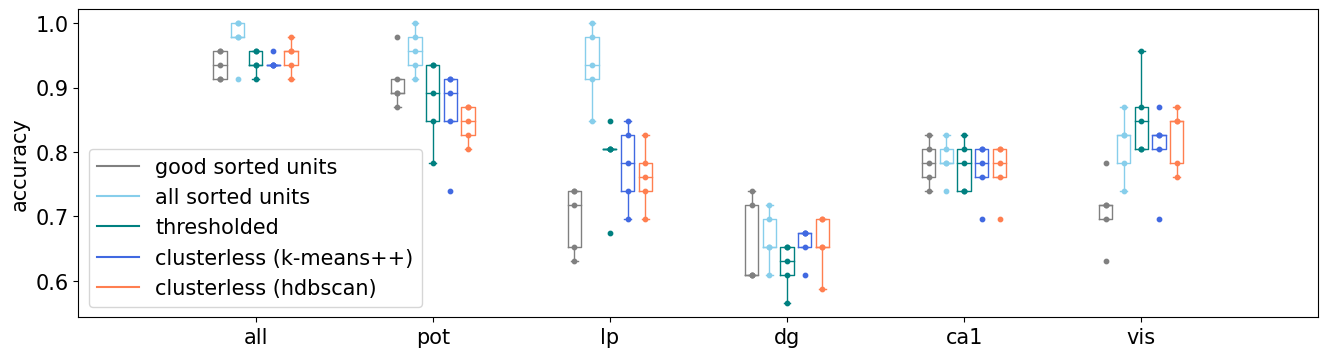

In [43]:
# box plots for choice
plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='accuracy', n_folds=5, add_smooth=False, fig_size=(16,4), save_fig=True)

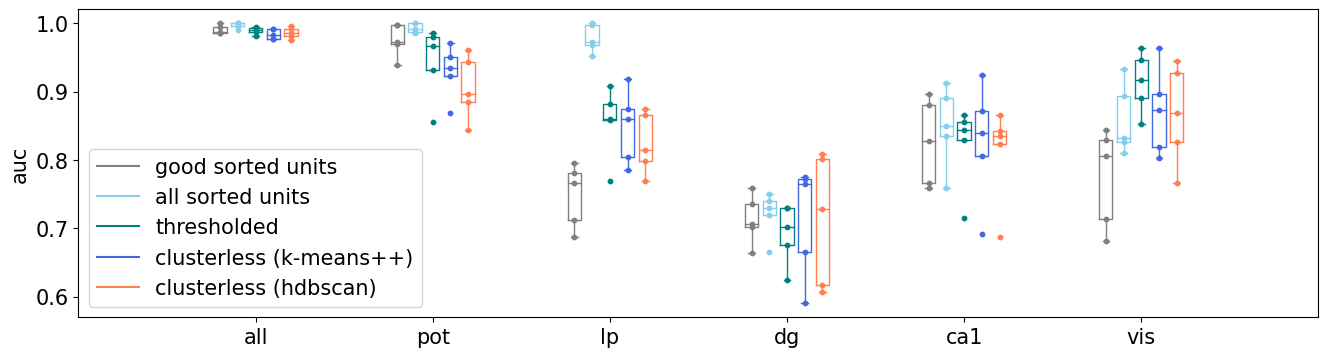

In [44]:
# box plots for choice
plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='auc', n_folds=5, add_smooth=False, fig_size=(16,4), save_fig=True)

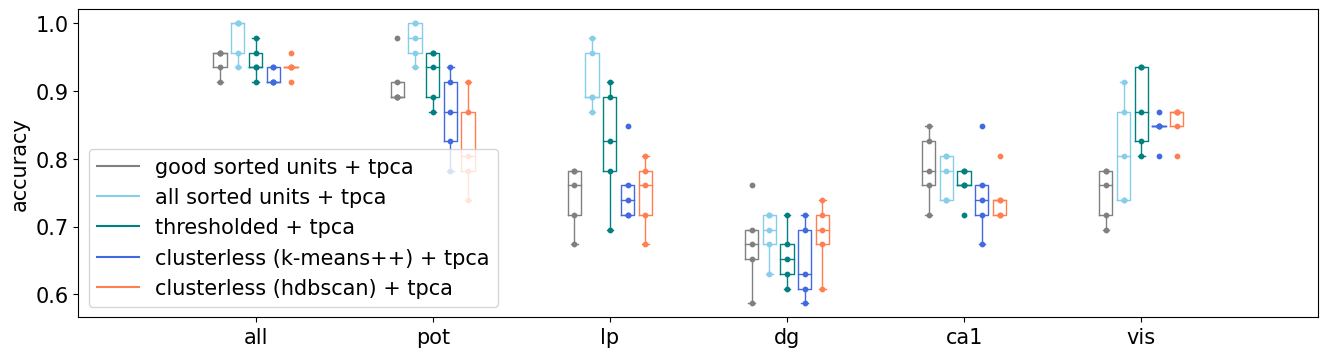

In [45]:
# box plots for choice + tpca
plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='accuracy', n_folds=5, add_smooth=True, fig_size=(16,4), save_fig=True)

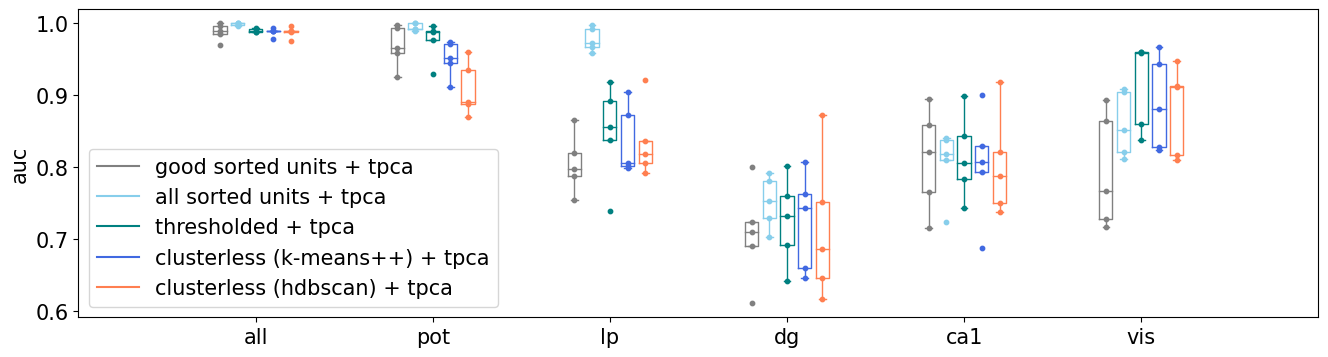

In [46]:
# box plots for choice + tpca
plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='auc', n_folds=5, add_smooth=True, fig_size=(16,4), save_fig=True)

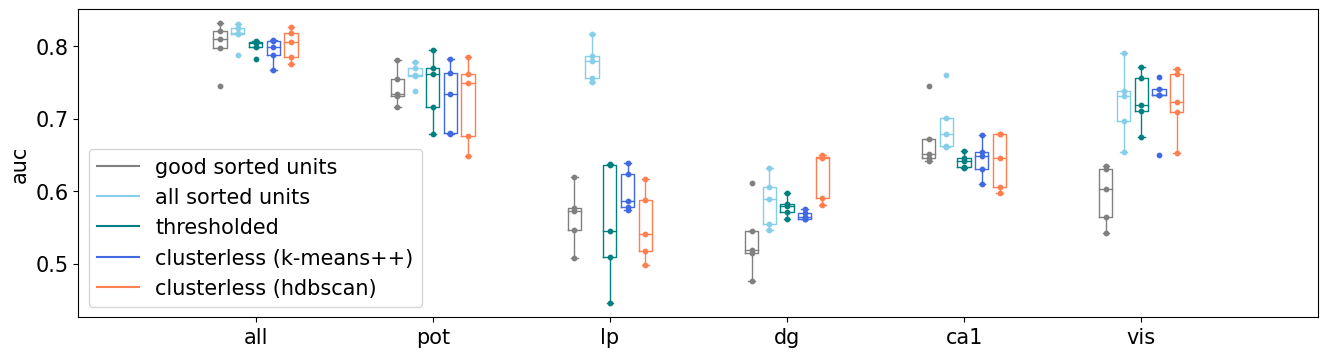

In [47]:
# box plots for stimulus
plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='auc', n_folds=5, add_smooth=False, fig_size=(16,4), save_fig=True)

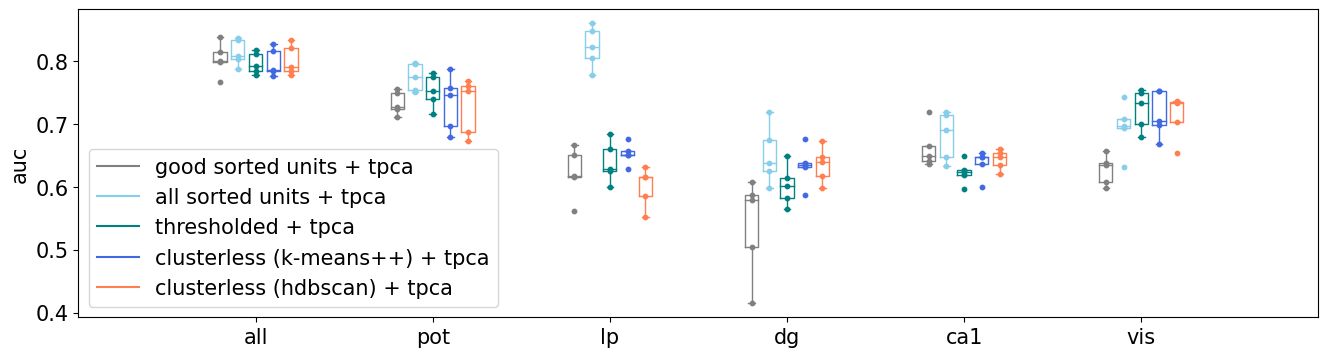

In [48]:
# box plots for stimulus + tpca
plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='auc', n_folds=5, add_smooth=True, fig_size=(16,4), save_fig=True)